In [2]:
import pandas as pd

In [3]:
X = pd.DataFrame({'city':['tokyo', None, 'london', 'seattle', 'san francisco', 'tokyo'],
                  'boolean':['yes', 'no', None, 'no', 'no', 'yes'],
                  'ordinal_column':['somewhat like', 'like', 'somewhat like', 'like', 'somewhat like', 'dislike'],
                  'quantitative_column':[1, 11, -.5, 10, None, 20]})

In [4]:
print(X)

            city boolean ordinal_column  quantitative_column
0          tokyo     yes  somewhat like                  1.0
1           None      no           like                 11.0
2         london    None  somewhat like                 -0.5
3        seattle      no           like                 10.0
4  san francisco      no  somewhat like                  NaN
5          tokyo     yes        dislike                 20.0


boolean: binary category(nominal level)<br>
city: categorical data(nominal level)<br>
ordinal_column: ordinal data(ordinal level)<br>
quantitative_column: ratio level<br>

In [5]:
X.isnull().sum()

city                   1
boolean                1
ordinal_column         0
quantitative_column    1
dtype: int64

In [6]:
# This is the most frequent element in city.
X['city'].value_counts().index[0]

'tokyo'

In [7]:
X['city'].fillna(X['city'].value_counts().index[0])

0            tokyo
1            tokyo
2           london
3          seattle
4    san francisco
5            tokyo
Name: city, dtype: object

We create a custom category imputer to process category data.

In [8]:
#TransformerMixin has 1 fit and 1 transform function.
from sklearn.base import TransformerMixin

class CustomCategoryImputer(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        
    def transform(self, df):
        X = df.copy()
        for col in self.cols:
            X[col].fillna(X[col].value_counts().index[0], inplace=True)
        return X
    
    def fit(self, *_):
        return self

In [9]:
cci = CustomCategoryImputer(cols=['city', 'boolean'])
cci.fit_transform(X)

/tmp/ipykernel_33/3257943780.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].value_counts().index[0], inplace=True)
/tmp/ipykernel_33/3257943780.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


In [10]:
from sklearn.impute import SimpleImputer

class CustomQuantitativeImputer(TransformerMixin):
    def __init__(self, cols=None, strategy='mean'):
        self.cols = cols
        self.strategy = strategy
    
    def transform(self, df):
        X = df.copy()
        impute = SimpleImputer(strategy=self.strategy)
        for col in self.cols:
            X[col] = impute.fit_transform(X[[col]])
        return X
    
    def fit(self, *_):
        return self

In [11]:
cqi = CustomQuantitativeImputer(cols=['quantitative_column'], strategy='mean')
cqi.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,8.3
5,tokyo,yes,dislike,20.0


We can also put the CustomCategoryImputer and CustomQuantitativeImputer together and call it.

In [12]:
from sklearn.pipeline import Pipeline

imputer = Pipeline([('quant', cqi), ('category', cci)])
imputer.fit_transform(X)

/tmp/ipykernel_33/3257943780.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].value_counts().index[0], inplace=True)
/tmp/ipykernel_33/3257943780.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,8.3
5,tokyo,yes,dislike,20.0


Now we need to change categorical data to numerical data. By using dummy variable, we can represent the nominal level. Beware categories that are related, such as female=0 and male=1 are repeated, therefore we need to ignore or set 1 variable as basic to compare with others.

In [13]:
pd.get_dummies(X, columns=['city', 'boolean'], prefix_sep='_')
# prefix sep is to separate columnName and value

,ordinal_column,quantitative_column,city_london,city_san francisco,city_seattle,city_tokyo,boolean_no,boolean_yes
0,somewhat like,1.0,False,False,False,True,False,True
1,like,11.0,False,False,False,False,True,False
2,somewhat like,-0.5,True,False,False,False,False,False
3,like,10.0,False,False,True,False,True,False
4,somewhat like,NaN,False,True,False,False,True,False
5,dislike,20.0,False,False,False,True,False,True


Another method is to create dummifier to change all the data in bulk.

In [14]:
class CustomDummifier(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        
    def transform(self, X):
        return pd.get_dummies(X, columns=self.cols)
    
    def fit(self, *_):
        return self

In [15]:
cd = CustomDummifier(cols=['boolean', 'city'])
cd.fit_transform(X)

,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_san francisco,city_seattle,city_tokyo
0,somewhat like,1.0,False,True,False,False,False,True
1,like,11.0,True,False,False,False,False,False
2,somewhat like,-0.5,False,False,True,False,False,False
3,like,10.0,True,False,False,False,True,False
4,somewhat like,NaN,True,False,False,True,False,False
5,dislike,20.0,False,True,False,False,False,True


Now we need to use label encoder to deal with the ordinal columns, it can let the categorical ordered instead of randomly encoding.

In [17]:
ordering = ['dislike', 'somewhat like', 'like']
print(X['ordinal_column'])

0    somewhat like
1             like
2    somewhat like
3             like
4    somewhat like
5          dislike
Name: ordinal_column, dtype: object


In [18]:
# we map the value to the index in ordering.
print(X['ordinal_column'].map(lambda x: ordering.index(x)))

0    1
1    2
2    1
3    2
4    1
5    0
Name: ordinal_column, dtype: int64


LabelEncoder cannot encode it sequentially, it use a sorting method.

In [19]:
class CustomEncoder(TransformerMixin):
    def __init__(self, col, ordering=None):
        self.ordering = ordering
        self.col = col
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = X[self.col].map(lambda x: self.ordering.index(x))
        return X
    
    def fit(self, *_):
        return self

In [20]:
ce = CustomEncoder(col='ordinal_column', ordering=['dislike', 'somewhat like', 'like'])
ce.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,1,1.0
1,None,no,2,11.0
2,london,None,1,-0.5
3,seattle,no,2,10.0
4,san francisco,no,1,NaN
5,tokyo,yes,0,20.0


Now we deal with continuous data, such as using cut for binning(分箱) or bucketing(分桶)

In [21]:
pd.cut(X['quantitative_column'], bins=3)

0     (-0.52, 6.333]
1    (6.333, 13.167]
2     (-0.52, 6.333]
3    (6.333, 13.167]
4                NaN
5     (13.167, 20.0]
Name: quantitative_column, dtype: category
Categories (3, interval[float64, right]): [(-0.52, 6.333] < (6.333, 13.167] < (13.167, 20.0]]

In [22]:
#we can also choose not to use the tag, just showing return which bin.
pd.cut(X['quantitative_column'], bins=3, labels=False)

0    0.0
1    1.0
2    0.0
3    1.0
4    NaN
5    2.0
Name: quantitative_column, dtype: float64

In [24]:
class CustomCutter(TransformerMixin):
    def __init__(self, col, bins, labels=False):
        self.labels = labels
        self.bins = bins
        self.col = col
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = pd.cut(X[self.col], bins=self.bins, labels=self.labels)
        return X
    
    def fit(self, *_):
        return self

In [25]:
cc = CustomCutter(col='quantitative_column', bins=3)
cc.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,0.0
1,None,no,like,1.0
2,london,None,somewhat like,0.0
3,seattle,no,like,1.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,2.0


Now the qunatitative_column becomes ordinal, we don't need to introduce dummy variable.

# Combine all <br>
1. impute value
2. use dummy value filling categories
3. encoding ordinal_column
4. binning quantitative_column

In [26]:
pipe = Pipeline([("imputer", imputer), ('dummify', cd), ('encode', ce), ('cut', cc)])

In [27]:
#Before
print(X)

            city boolean ordinal_column  quantitative_column
0          tokyo     yes  somewhat like                  1.0
1           None      no           like                 11.0
2         london    None  somewhat like                 -0.5
3        seattle      no           like                 10.0
4  san francisco      no  somewhat like                  NaN
5          tokyo     yes        dislike                 20.0


In [28]:
#After
pipe.fit(X)

/tmp/ipykernel_33/3257943780.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].value_counts().index[0], inplace=True)
/tmp/ipykernel_33/3257943780.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

Pipeline(steps=[('imputer',
                 Pipeline(steps=[('quant',
                                  <__main__.CustomQuantitativeImputer object at 0x7de3be7d7bb0>),
                                 ('category',
                                  <__main__.CustomCategoryImputer object at 0x7de3cb10e950>)])),
                ('dummify',
                 <__main__.CustomDummifier object at 0x7de3cb10fb80>),
                ('encode', <__main__.CustomEncoder object at 0x7de3ba928fa0>),
                ('cut', <__main__.CustomCutter object at 0x7de3de4cfdf0>)])

In [29]:
pipe.transform(X)

/tmp/ipykernel_33/3257943780.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].value_counts().index[0], inplace=True)
/tmp/ipykernel_33/3257943780.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_san francisco,city_seattle,city_tokyo
0,1,0,False,True,False,False,False,True
1,2,1,True,False,False,False,False,True
2,1,0,True,False,True,False,False,False
3,2,1,True,False,False,False,True,False
4,1,1,True,False,False,True,False,False
5,0,2,False,True,False,False,False,True


# Dataset: Accelerometer<br>
This dataset is on http://archive.ics.uci.edu/dataset/287/activity+recognition+from+single+chest+mounted+accelerometer<br>

Data are separated by participant<br>

Each file contains the following information<br>

   ---- sequential number, x acceleration, y acceleration, z acceleration, label <br>

Labels are codified by numbers<br>

   --- 1: Working at Computer<br>

   --- 2: Standing Up, Walking and Going updown stairs<br>

   --- 3: Standing<br>

   --- 4: Walking<br>

   --- 5: Going UpDown Stairs<br>

   --- 6: Walking and Talking with Someone<br>

   --- 7: Talking while Standing<br>

In [30]:
url = "https://raw.githubusercontent.com/PacktPublishing/Feature-Engineering-Made-Easy/master/Chapter04/activity_recognizer/1.csv"
df = pd.read_csv(url)
df.columns = ['index', 'x', 'y', 'z', 'activity']

In [31]:
df.head()

,index,x,y,z,activity
0,1.0,1667,2072,2047,1
1,2.0,1611,1957,1906,1
2,3.0,1601,1939,1831,1
3,4.0,1643,1965,1879,1
4,5.0,1604,1959,1921,1


In [32]:
df['activity'].value_counts(normalize=True)

activity
7    0.515372
1    0.207237
4    0.165292
3    0.068794
5    0.019637
6    0.017951
2    0.005711
0    0.000006
Name: proportion, dtype: float64

Null accuracy is 51.53%, wich means our model should be higher than this value just by guessing.

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

X = df[['x', 'y', 'z']]
y = df['activity']

knn_params = {'n_neighbors': [3, 4, 5, 6]}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, knn_params)
grid.fit(X, y)

print(grid.best_score_, grid.best_params_)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


0.7367569230769231 {'n_neighbors': 5}


We use a constructor to capture new feature interactions between variables, it will be polynomial features.<br>
For example in 2d: [a,b] , the feature will be [1, a, b, a^2, ab, b^2]. <br>
degree is the polynomial rank: default = 2<br>
interaction_only means only generate the variable that have interaction with others, a^2, b^2 will be ignored.<br>
include_bias: if True, generate a bias column with rank=0, which everything will be 1 in the column.

In [35]:
from sklearn.preprocessing import PolynomialFeatures

# We set interaction_only to False now.
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

X_poly = poly.fit_transform(X)
X_poly.shape

(162500, 9)

In [37]:
# get the name of the columns
pd.DataFrame(X_poly, columns=poly.get_feature_names_out())

,x,y,z,x^2,x y,x z,y^2,y z,z^2
0,1667.0,2072.0,2047.0,2778889.0,3454024.0,3412349.0,4293184.0,4241384.0,4190209.0
1,1611.0,1957.0,1906.0,2595321.0,3152727.0,3070566.0,3829849.0,3730042.0,3632836.0
2,1601.0,1939.0,1831.0,2563201.0,3104339.0,2931431.0,3759721.0,3550309.0,3352561.0
3,1643.0,1965.0,1879.0,2699449.0,3228495.0,3087197.0,3861225.0,3692235.0,3530641.0
4,1604.0,1959.0,1921.0,2572816.0,3142236.0,3081284.0,3837681.0,3763239.0,3690241.0
...,...,...,...,...,...,...,...,...,...
162495,1927.0,2388.0,2074.0,3713329.0,4601676.0,3996598.0,5702544.0,4952712.0,4301476.0
162496,1930.0,2383.0,2074.0,3724900.0,4599190.0,4002820.0,5678689.0,4942342.0,4301476.0
162497,1929.0,2385.0,2076.0,3721041.0,4600665.0,4004604.0,5688225.0,4951260.0,4309776.0
162498,1926.0,2385.0,2078.0,3709476.0,4593510.0,4002228.0,5688225.0,4956030.0,4318084.0


<Axes: >

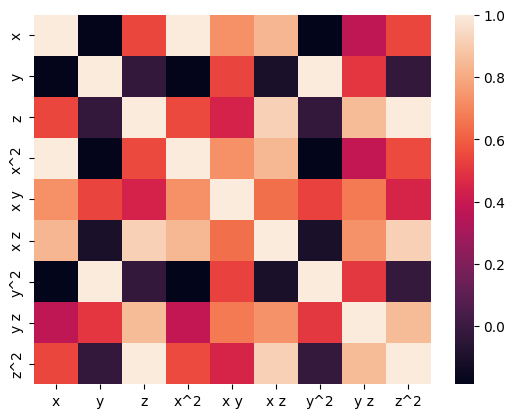

In [38]:
# ploting
%matplotlib inline
import seaborn as sns

sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names_out()).corr())

In [40]:
# We set interaction_only to True now
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_poly = poly.fit_transform(X)
X_poly.shape

(162500, 6)

In [41]:
pd.DataFrame(X_poly, columns=poly.get_feature_names_out())

,x,y,z,x y,x z,y z
0,1667.0,2072.0,2047.0,3454024.0,3412349.0,4241384.0
1,1611.0,1957.0,1906.0,3152727.0,3070566.0,3730042.0
2,1601.0,1939.0,1831.0,3104339.0,2931431.0,3550309.0
3,1643.0,1965.0,1879.0,3228495.0,3087197.0,3692235.0
4,1604.0,1959.0,1921.0,3142236.0,3081284.0,3763239.0
...,...,...,...,...,...,...
162495,1927.0,2388.0,2074.0,4601676.0,3996598.0,4952712.0
162496,1930.0,2383.0,2074.0,4599190.0,4002820.0,4942342.0
162497,1929.0,2385.0,2076.0,4600665.0,4004604.0,4951260.0
162498,1926.0,2385.0,2078.0,4593510.0,4002228.0,4956030.0


<Axes: >

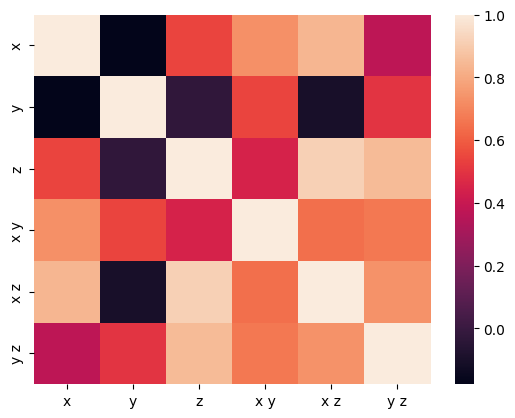

In [42]:
sns.heatmap(pd.DataFrame(X_poly,columns=poly.get_feature_names_out()).corr())

Now we use GridSearchCV with KNN to check the score.

In [ ]:
pipe_params = {'poly_features__degree':[1, 2, 3], 'poly_features__interaction_only':[True, False],
               'classify__n_neighbors':[3, 4, 5, 6]}

from sklearn.pipeline import Pipeline

pipe = Pipeline([('poly_features', poly), ('classify', knn)])

grid = GridSearchCV(pipe, pipe_params)
grid.fit(X, y)

print(grid.best_score_, grid.best_params_)

In [44]:
print(grid.best_score_, grid.best_params_)

0.7401292307692309 {'classify__n_neighbors': 5, 'poly_features__degree': 2, 'poly_features__interaction_only': True}
